In [1]:
#import packages and set default data type
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd
from torchvision.io import read_image

torch.set_default_dtype(torch.float64)

We first create a module which corresponds to a tropical binomial $\max(\mathbf{w}_1^\top \mathbf{x} + p_{\mathbf{w}_1}, \mathbf{w}_2^\top \mathbf{x} + p_{\mathbf{w}_2})$.

In [2]:
class BinomialBlock(nn.Module):
    def __init__(self,p_w_1,p_w_2,w_1,w_2,initialize):
        super(BinomialBlock, self).__init__()
        self.flatten = nn.Flatten()
        
        #number of variables
        n = w_1.size
        
        #create network architecture
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n,3),
            nn.ReLU(),
            nn.Linear(3,1)
        )
        
        #fill weights
        if initialize == 1:
            
            weight_mat = np.array([w_1 - w_2, w_2, -w_2])
            bias_vec = np.array([p_w_1[0] - p_w_2[0],p_w_2[0],-p_w_2[0]])
            
            self.linear_relu_stack[0].weight = nn.parameter.Parameter(torch.from_numpy(weight_mat))
            self.linear_relu_stack[0].bias   = nn.parameter.Parameter(torch.from_numpy(bias_vec))
        
            output_weight = torch.tensor([[1., 1., -1.]])
            self.linear_relu_stack[2].weight = nn.parameter.Parameter(output_weight)
        
            output_bias = torch.tensor([0.])
            self.linear_relu_stack[2].bias = nn.parameter.Parameter(output_bias)
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

Next, we define a class that returns a fully connected ReLU network which returns the maximum of two input fully connected ReLU networks of the same size. 

In [3]:
class CombineNets(nn.Module):
    def __init__(self,net_1,net_2):
        super(CombineNets,self).__init__()
        self.flatten = nn.Flatten()

        #Combine Hidden Layers of input networks
        output_layer_index = len(net_1.linear_relu_stack) -1
        n_hidden_linear_layers = int(0.5*(output_layer_index))
        
        #initialize lists to store linear pieces and parameters
        linear_relu_stack_list = []
        weight_tensors = []
        bias_tensors = []
        
        for i in range(n_hidden_linear_layers):
            index = 2*i
            
            #input layer concatenates matrices
            if index == 0:
                input_weight_1 = net_1.linear_relu_stack[index].weight
                input_weight_2 = net_2.linear_relu_stack[index].weight
                
                #weights for input layer
                concat_weight = torch.cat((input_weight_1, input_weight_2),dim = 0)
                weight_tensors.append(concat_weight)
                
                #size of input layer
                size = concat_weight.size()
                linear_relu_stack_list.append(nn.Linear(size[1],size[0]))
                linear_relu_stack_list.append(nn.ReLU())
                
                #bias of input layer
                input_bias_1 = net_1.linear_relu_stack[index].bias
                input_bias_2 = net_2.linear_relu_stack[index].bias
                concat_bias = torch.cat((input_bias_1,input_bias_2))
                bias_tensors.append(concat_bias)
            
            #Other hidden layers form block matrices
            else:
                input_weight_1 = net_1.linear_relu_stack[index].weight
                size_1 = input_weight_1.size()
                
                input_weight_2 = net_2.linear_relu_stack[index].weight
                size_2 = input_weight_2.size()
                
                Z = torch.zeros((size_1[0],size_2[1]))
                
                #weights for layer
                top = torch.cat((input_weight_1,Z),dim = 1)
                bottom = torch.cat((Z,input_weight_2),dim = 1)
                concat_weight = torch.cat((top,bottom),dim = 0)
                weight_tensors.append(concat_weight)
                                     
                #size of layer    
                size = concat_weight.size()
                linear_relu_stack_list.append(nn.Linear(size[1],size[0]))
                linear_relu_stack_list.append(nn.ReLU())                              
                
                #bias of layer
                input_bias_1 = net_1.linear_relu_stack[index].bias
                input_bias_2 = net_2.linear_relu_stack[index].bias
                concat_bias = torch.cat((input_bias_1,input_bias_2))
                bias_tensors.append(concat_bias)
                
        #Outputs of net_1,net_2
        net_1_output_weight = net_1.linear_relu_stack[output_layer_index].weight
        net_2_output_weight = net_2.linear_relu_stack[output_layer_index].weight
        
        Z = torch.zeros(net_1_output_weight.size())
        top = torch.cat((net_1_output_weight,-net_2_output_weight),dim = 1)
        mid = torch.cat((Z,net_2_output_weight),dim = 1)
        bottom = torch.cat((Z,-net_2_output_weight),dim = 1)
                
        concat_weight = torch.cat((top,mid,bottom),dim = 0)
        concat_weight = concat_weight
        size = concat_weight.size()
                                                
        #weights of output layers    
        weight_tensors.append(concat_weight)
        
        #size of otuput layers
        linear_relu_stack_list.append(nn.Linear(size[1],size[0]))
        linear_relu_stack_list.append(nn.ReLU())
        
        #bias of output layers
        bias_tens = torch.zeros(size[0])
        bias_tensors.append(bias_tens)
        
        #Max of Outputs of net_1,net_2 (create output layer of new net) 
        linear_relu_stack_list.append(nn.Linear(3,1))
        
        #weights
        output_weight = np.array([[1., 1., -1.]])
        output_weight = torch.from_numpy(output_weight) 
        weight_tensors.append(output_weight)
        
        #bias
        bias_mat = np.array([0.])
        bias_tens = torch.tensor(bias_mat)
        bias_tensors.append(bias_tens)
        
        #Create Net Architecture
        self.linear_relu_stack = nn.Sequential(*linear_relu_stack_list)
        
        #Populate values for weights and biases
        for index in range(len(weight_tensors)):
            weight = weight_tensors[index]
            bias = bias_tensors[index]
            
            self.linear_relu_stack[2*index].weight = nn.parameter.Parameter(weight)
            self.linear_relu_stack[2*index].bias = nn.parameter.Parameter(bias)
            
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Finally, we create a fully connected ReLU network corresponding to an input tropical rational function.

In [4]:
class TropicalNet(nn.Module):
    def __init__(self,num,denom,exps,initialize):
        super(TropicalNet,self).__init__()
        self.flatten = nn.Flatten()
        
        num_coefficients = pd.read_csv(num)
        num_coefficients = num_coefficients.values
        
        den_coefficients = pd.read_csv(denom)
        den_coefficients = den_coefficients.values
        
        exponents = pd.read_csv(exps)
        exponents = exponents.values
        exponents = exponents.astype(np.float64)
                
        n_terms = len(exponents)

        #Shuffle the pairings of monomials
        arr = np.arange(n_terms)
        np.random.shuffle(arr)
    
        #build binomial blocks
        num_binom_blocks = [] 
        den_binom_blocks = []
        for i in range(0,n_terms,2):
            
            index = arr[i]
            next_index = arr[i+1]
            
            num_binom_blocks.append(BinomialBlock(num_coefficients[index],num_coefficients[next_index],exponents[index],exponents[next_index],initialize))
            den_binom_blocks.append(BinomialBlock(den_coefficients[index],den_coefficients[next_index],exponents[index],exponents[next_index],initialize))
            
        #combine all binomial blocks for numerator and denominator
        while len(num_binom_blocks) >=2:
            new_num_blocks = list()
            new_den_blocks = list()
                                            
            for i in range(0,len(num_binom_blocks),2):
                new_num_blocks.append(CombineNets(num_binom_blocks[i],num_binom_blocks[i+1]))
                new_den_blocks.append(CombineNets(den_binom_blocks[i],den_binom_blocks[i+1]))
                
            num_binom_blocks = new_num_blocks
            den_binom_blocks = new_den_blocks
        
        #networks corresponding to numerator and denominator
        net_1 = num_binom_blocks[0]
        net_2 = den_binom_blocks[0]
        
        #Combine Hidden Layers of input networks
        output_layer_index = len(net_1.linear_relu_stack) -1
        n_hidden_linear_layers = int(0.5*(output_layer_index))
        
        linear_relu_stack_list = []
        weight_tensors = []
        bias_tensors = []
        
        for i in range(n_hidden_linear_layers):
            index = 2*i
            
            #input layer concatenates matrices
            if index == 0:
                input_weight_1 = net_1.linear_relu_stack[index].weight
                input_weight_2 = net_2.linear_relu_stack[index].weight
                
                concat_weight = torch.cat((input_weight_1, input_weight_2),dim = 0)
                weight_tensors.append(concat_weight)
                
                size = concat_weight.size()
                linear_relu_stack_list.append(nn.Linear(size[1],size[0]))
                linear_relu_stack_list.append(nn.ReLU())
                
                input_bias_1 = net_1.linear_relu_stack[index].bias
                input_bias_2 = net_2.linear_relu_stack[index].bias
                
                concat_bias = torch.cat((input_bias_1,input_bias_2))
                bias_tensors.append(concat_bias)
            
            #Other hidden layers form block matrices
            else:
                input_weight_1 = net_1.linear_relu_stack[index].weight
                size_1 = input_weight_1.size()
                
                input_weight_2 = net_2.linear_relu_stack[index].weight
                size_2 = input_weight_2.size()
                
                Z = torch.zeros((size_1[0],size_2[1]))
                                
                top = torch.cat((input_weight_1,Z),dim = 1)
                bottom = torch.cat((Z,input_weight_2),dim = 1)
                
                concat_weight = torch.cat((top,bottom),dim = 0)
                weight_tensors.append(concat_weight)
                                              
                size = concat_weight.size()
                linear_relu_stack_list.append(nn.Linear(size[1],size[0]))
                linear_relu_stack_list.append(nn.ReLU())                              
                                              
                input_bias_1 = net_1.linear_relu_stack[index].bias
                input_bias_2 = net_2.linear_relu_stack[index].bias
                
                concat_bias = torch.cat((input_bias_1,input_bias_2))
                bias_tensors.append(concat_bias)
                
        #Difference of Outputs net_1 - net_2
        net_1_output_weight = net_1.linear_relu_stack[output_layer_index].weight
        net_2_output_weight = net_2.linear_relu_stack[output_layer_index].weight
        
        size = net_1_output_weight.size()
        
        #This weight gives net_1 - net_2
        final_weight = torch.cat((net_1_output_weight, - net_2_output_weight),dim = 1)
        weight_tensors.append(final_weight)
        
        linear_relu_stack_list.append(nn.Linear(2*size[1],size[0]))
        
        bias_mat = np.array([0.])
        bias_tens = torch.tensor(bias_mat)
        bias_tens = bias_tens.type(torch.DoubleTensor)
        bias_tensors.append(bias_tens)
        
        #Create Net Architecture
        self.linear_relu_stack = nn.Sequential(*linear_relu_stack_list)
        
        #Populate values
        if initialize == 1:
            for index in range(len(weight_tensors)):
                weight = weight_tensors[index]
                bias = bias_tensors[index]
                
                if index < len(weight_tensors) - 1:
                    size = weight.size()
                    weight = weight
                    bias = bias
                    
                    weight_tensors[index + 1] = weight_tensors[index+1]
                    
                self.linear_relu_stack[2*index].weight = nn.parameter.Parameter(weight)
                self.linear_relu_stack[2*index].bias = nn.parameter.Parameter(bias)
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Network Initialization Experiments

### Sine curve from degree 15 tropical rational function

In [5]:
def train_loop(x,y,batch_size,model,loss_fn,optimizer):
    
    N_data = len(y);
    data_indices = np.array(range(N_data))
    np.random.shuffle(data_indices)    
    N_batches = int(np.floor(N_data/batch_size))
    
    
    for batch in range(N_batches):
        batch_indices = data_indices[batch*batch_size:(batch+1)*batch_size]        
        batch_x = torch.from_numpy(x[batch_indices,:])
        batch_y = torch.from_numpy(y[batch_indices,:])
        
        pred = model(batch_x)
        loss = loss_fn(pred,batch_y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if N_batches*batch_size != N_data:
        batch_indices = data_indices[N_batches*batch_size:]
        batch_x = torch.from_numpy(x[batch_indices,:])
        batch_y = torch.from_numpy(y[batch_indices,:])
        
        pred = model(batch_x)
        loss = loss_fn(pred,batch_y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #compute total loss
    all_x = torch.from_numpy(x)
    all_y = torch.from_numpy(y)
    
    pred = model(all_x)
    loss = loss_fn(pred,all_y)
    
    return loss.item()

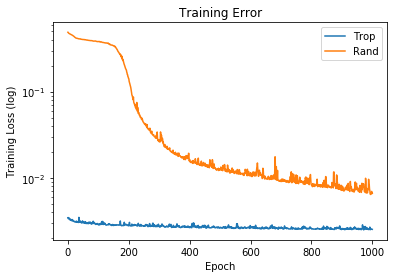

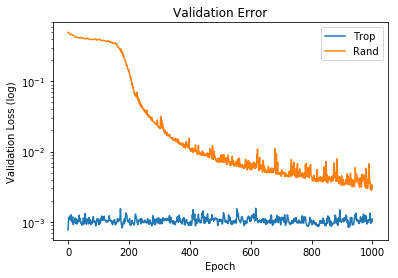

In [11]:
initialize = 1
Sin_Trop_Net = TropicalNet("15sin_num.csv","15sin_den.csv","15sin_exps.csv",initialize)

learning_rate = 5*1e-6
batch_size = 64

loss_fn = nn.MSELoss()
Sin_Trop_optimizer = torch.optim.Adam(Sin_Trop_Net.parameters(), lr=learning_rate)

n_epochs = 1000
epochs = np.linspace(1,n_epochs, num = n_epochs)
Sin_Trop_Net_loss = np.zeros(n_epochs)

x = pd.read_csv("sin_x.csv");
x = x.values;
y = pd.read_csv("sin_y.csv")
y = y.values;

Sin_Trop_Net_init_pred = Sin_Trop_Net(torch.from_numpy(x));
loss = loss_fn(Sin_Trop_Net_init_pred,torch.from_numpy(y))
Sin_Trop_Net_init_loss = loss.item()

#Randomly generated validation set
val_x = 13*torch.rand(200,1) - torch.ones(200,1);
val_y = torch.from_numpy(np.sin(val_x.detach().numpy()))

Sin_Trop_Net_Val = np.zeros(n_epochs)

#Train
for t in range(n_epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    Sin_Trop_Net_loss[t] = train_loop(x,y,batch_size, Sin_Trop_Net, loss_fn, Sin_Trop_optimizer)
    
    #validation
    val_pred = Sin_Trop_Net(val_x)
    loss = loss_fn(val_pred,val_y)
    Sin_Trop_Net_Val[t] = loss.item()


#Randomly initialized network
dont_initialize = 0
Sin_Control_Net = TropicalNet("15sin_num.csv","15sin_den.csv","15sin_exps.csv",dont_initialize)

learning_rate = 1e-3
batch_size = 64

loss_fn = nn.MSELoss()
Sin_Control_optimizer = torch.optim.Adam(Sin_Control_Net.parameters(), lr=learning_rate)

n_epochs = 1000
epochs = np.linspace(0,n_epochs, num = n_epochs)
Sin_Control_Net_loss = np.zeros(n_epochs)
Sin_Control_Net_Val  = np.zeros(n_epochs)

Sin_Control_Net_init_pred = Sin_Control_Net(torch.from_numpy(x));
loss = loss_fn(Sin_Control_Net_init_pred,torch.from_numpy(y))
Sin_Control_Net_init_loss = loss.item()

for t in range(n_epochs):
    Sin_Control_Net_loss[t] = train_loop(x,y,batch_size, Sin_Control_Net, loss_fn, Sin_Control_optimizer)

    #validation
    val_pred = Sin_Control_Net(val_x)
    loss = loss_fn(val_pred,val_y)
    Sin_Control_Net_Val[t] = loss.item()


fig, ax4 = plt.subplots()
ax4.semilogy(epochs,Sin_Trop_Net_loss, label = 'Trop')
ax4.semilogy(epochs,Sin_Control_Net_loss,label = 'Rand')
ax4.set_title('Training Error')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Training Loss (log)')
ax4.legend()
#plt.savefig('Sin15_train.pdf')
plt.show()

fig,ax5 = plt.subplots()
ax5.semilogy(epochs,Sin_Trop_Net_Val, label = 'Trop')
ax5.semilogy(epochs, Sin_Control_Net_Val,label = 'Rand')
ax5.set_title('Validation Error')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Validation Loss (log)')
ax5.legend()
#plt.savefig('Sin15_Test.pdf')
plt.show()

In [17]:
#Save data to create tikz plots
Sin_errs = np.array([epochs,Sin_Trop_Net_loss,Sin_Control_Net_loss,Sin_Trop_Net_Val,Sin_Control_Net_Val])
Sin_errs_df = pd.DataFrame(Sin_errs.transpose(),columns = ['Epochs','Trop Train','Rand Train','Trop Val','Rand Val'])
Sin_errs_df.to_csv('Sin_NN_Errs.csv')

In [16]:
print(max(val_x))

tensor([11.9739])


### Peaks Data

Trop Initialized Loss:
0.15478150647506533
Random Initialized Loss:
3.5124223113425224


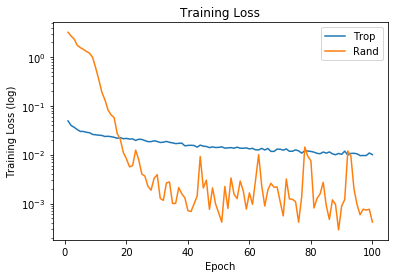

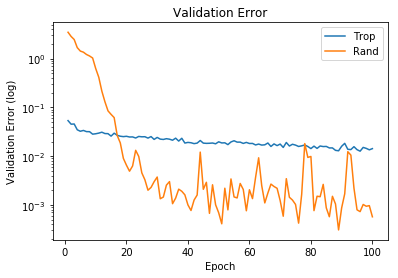

In [8]:
learning_rate_trop = 1e-7
learning_rate_rand = 1e-4

initialize = 1
Peaks_Trop_Net = TropicalNet("peaks_num.csv","peaks_den.csv","peaks_ex.csv",initialize)
Peaks_Trop_optimizer = torch.optim.Adam(Peaks_Trop_Net.parameters(), lr=learning_rate_trop)

dont_initialize = 0
Peaks_Control_Net = TropicalNet("peaks_num.csv","peaks_den.csv","peaks_ex.csv",dont_initialize)
Peaks_Control_optimizer = torch.optim.Adam(Peaks_Control_Net.parameters(), lr=learning_rate_rand)

batch_size = 64

loss_fn = nn.MSELoss()

z = pd.read_csv("Peaks_Z.csv")
z = np.reshape(z.values,(49*49,1))
        
x = pd.read_csv("Peaks_X.csv")
x = np.reshape(x.values,(49*49,1))
y = pd.read_csv("Peaks_Y.csv")
y = np.reshape(y.values,(49*49,1))

data_points = np.concatenate((x,y), axis = 1)

Peaks_Trop_Net_init_pred = Peaks_Trop_Net(torch.from_numpy(data_points));
loss = loss_fn(Peaks_Trop_Net_init_pred,torch.from_numpy(z))
Peaks_Trop_Net_init_loss = loss.item()

Peaks_Control_Net_init_pred = Peaks_Control_Net(torch.from_numpy(data_points));
loss = loss_fn(Peaks_Control_Net_init_pred,torch.from_numpy(z))
Peaks_Control_Net_init_loss = loss.item()

#sanity check
print('Trop Initialized Loss:')
loss = loss_fn(Peaks_Trop_Net(torch.from_numpy(data_points)),torch.from_numpy(z))
print(loss.item())

print('Random Initialized Loss:')
loss = loss_fn(Peaks_Control_Net(torch.from_numpy(data_points)),torch.from_numpy(z))
print(loss.item())


n_epochs = 100
epochs = np.linspace(1,n_epochs, num = n_epochs)
Peaks_Trop_Net_loss = np.zeros(n_epochs)
Peaks_Control_Net_loss = np.zeros(n_epochs)

val_x = np.random.uniform(-3.0,3.0,(200,1))
val_y = np.random.uniform(-3.0,3.0,(200,1))

val_points = np.concatenate((val_x,val_y), axis = 1);

val_z = 3*(np.ones((200,1)) - val_x)**2*np.exp(-val_x**2 - (val_y + np.ones((200,1)))**2) -10.*((1./5.)*val_x - val_x**3 - val_y**5)*np.exp(-val_x**2-val_y**2) - (1./3.)*np.exp(-(val_x + np.ones((200,1)))**2 - val_y**2)

val_tensor = torch.from_numpy(val_points)
val_z_tensor = torch.from_numpy(val_z)

Peaks_Trop_Net_Val = np.zeros(n_epochs)
Peaks_Control_Net_Val = np.zeros(n_epochs)

for t in range(n_epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    
    Peaks_Trop_Net_loss[t] = train_loop(data_points,z,batch_size, Peaks_Trop_Net, loss_fn, Peaks_Trop_optimizer)
    
    
    #print(Peaks_Trop_Net_loss[t])
    Peaks_Control_Net_loss[t] = train_loop(data_points,z,batch_size, Peaks_Control_Net, loss_fn, Peaks_Control_optimizer)
    
    #Test
    val_pred = Peaks_Trop_Net(val_tensor)
    loss = loss_fn(val_pred, val_z_tensor)
    Peaks_Trop_Net_Val[t] = loss.item()
    
    val_pred = Peaks_Control_Net(val_tensor)
    loss = loss_fn(val_pred, val_z_tensor)
    Peaks_Control_Net_Val[t] = loss.item()
    
fig, ax12 = plt.subplots()
ax12.semilogy(epochs,Peaks_Trop_Net_loss,label = 'Trop')
ax12.semilogy(epochs,Peaks_Control_Net_loss,label = 'Rand')
ax12.set_xlabel('Epoch')
ax12.set_ylabel('Training Loss (log)')
ax12.legend()
ax12.set_title('Training Loss')
#plt.savefig('Peaks3131NN_train_729.pdf')
plt.show()

fig, ax_peaks_val = plt.subplots()
ax_peaks_val.semilogy(epochs,Peaks_Trop_Net_Val, label = 'Trop')
ax_peaks_val.semilogy(epochs,Peaks_Control_Net_Val, label = 'Rand')
ax_peaks_val.set_xlabel('Epoch')
ax_peaks_val.set_ylabel('Validation Error (log)')
ax_peaks_val.legend()
ax_peaks_val.set_title('Validation Error')
#plt.savefig('Peaks3131NN_test_729.pdf')
plt.show()

In [9]:
#Save data to create tikz plots
Peaks_errs = np.array([epochs,Peaks_Trop_Net_loss,Peaks_Control_Net_loss,Peaks_Trop_Net_Val,Peaks_Control_Net_Val])
Peaks_errs_df = pd.DataFrame(Peaks_errs.transpose(),columns = ['Epochs','Trop Train','Rand Train','Trop Val','Rand Val'])
Peaks_errs_df.to_csv('Peaks_NN_Errs.csv')

In [10]:
print(Sin_Trop_Net)

TropicalNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=6, bias=True)
    (7): ReLU()
    (8): Linear(in_features=6, out_features=1, bias=True)
  )
)
